In [1]:
import pandas as pd
import numpy as np

COLUMN_NAMES = ['frame', 'track_id', 'type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top',
                'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']
df = pd.read_csv('/home/ky/data/kitti/tracking/training/label_02/0000.txt', header=None, sep=' ')
df.columns = COLUMN_NAMES
df.head()


,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
0,0,-1,DontCare,-1,-1,-10.000000,219.310000,188.490000,245.500000,218.560000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000
1,0,-1,DontCare,-1,-1,-10.000000,47.560000,195.280000,115.480000,221.480000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245


In [2]:
df.loc[df.type.isin(['Truck', 'Van', 'Tram']), 'type'] = 'Car'

In [3]:
df = df[df.type.isin(['Car', 'Pedestrian', 'Cyclist'])]

In [4]:
df.loc[2, ['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']]

bbox_left      296.745
bbox_top       161.752
bbox_right     455.226
bbox_bottom    292.373
Name: 2, dtype: object

In [5]:
box = np.array(df.loc[2, ['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']])
box

array([296.744956, 161.75214700000001, 455.22604200000001,
       292.37280400000003], dtype=object)

In [6]:
DETECTION_COLOR_DICT = {'Car':(255, 255, 0), 'Pedestrian':(0, 226, 255), 'Cyclist':(141, 40, 255)} #bgr

In [9]:
import cv2
frame = 120

image = cv2.imread('/home/ky/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/image_02/data/%010d.png'%frame)

boxes = np.array(df[df.frame==frame][['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']])
types = np.array(df[df.frame==frame]['type'])

for typ,box in zip(types, boxes):
    top_left = int(box[0]), int(box[1])
    bottom_right = int(box[2]), int(box[3])
    cv2.rectangle(image, top_left, bottom_right, DETECTION_COLOR_DICT[typ], 2)

cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
import pandas as pd
import numpy as np

IMU_COLUMN_NAMES = ['lat', 'lon', 'alt', 'roll', 'pitch', 'yaw', 'vn', 've', 'vf', 'vl', 'vu', 'ax', 'ay', 'az', 'af',
                    'al', 'au', 'wx', 'wy', 'wz', 'wf', 'wl', 'wu', 'posacc', 'velacc', 'navstat', 'numstat', 'posmode',
                    'velmode', 'orimode']

def read_imu(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = IMU_COLUMN_NAMES
    return df

def compute_great_circle_distance(lat1, lon1, lat2, lon2):
    """
    Compute the great circle distance from two gps data
    Input  : latitudes and longitudes in degree
    Output : distance in meter
    """
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0 * np.arccos(np.clip(delta_sigma, -1, 1))
    

In [23]:
prev_imu_data = None
gps_distances = []
imu_distances = []
for frame in range(150):
    imu_data = read_imu('/home/ky/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    
    if prev_imu_data is not None:
        gps_distances += [compute_great_circle_distance(imu_data.lat, imu_data.lon, prev_imu_data.lat, prev_imu_data.lon)]
        imu_distances += [0.1*np.linalg.norm(imu_data[['vf', 'vl']])]
            
    prev_imu_data = imu_data            

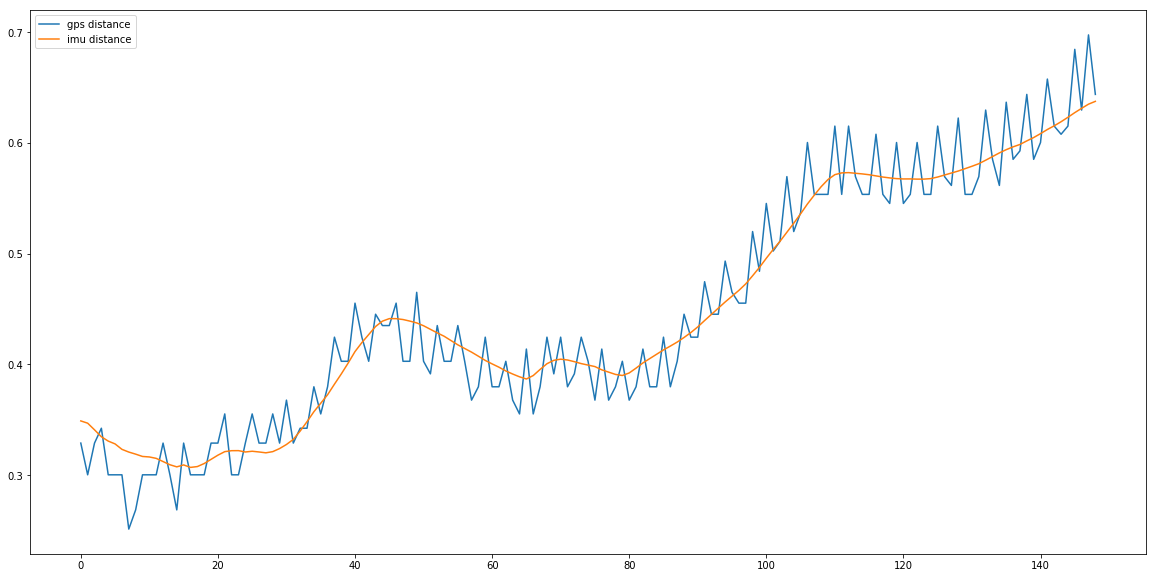

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(gps_distances, label='gps distance')
plt.plot(imu_distances, label='imu distance')
plt.legend()
plt.show()

In [2]:
read_imu('/home/ky/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/0000000000.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numstat,posmode,velmode,orimode
0,49.011213,8.422885,112.834923,0.022447,0.00001,-1.22191,-3.325632,1.138431,3.514768,0.037625,...,-0.017499,0.021393,0.14563,0.492294,0.068884,4,10,4,4,0


In [3]:
read_imu('/home/ky/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/0000000001.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numstat,posmode,velmode,orimode
0,49.01121,8.422887,112.846901,0.022857,0.004342,-1.206077,-3.288107,1.166745,3.488639,0.054704,...,-0.004166,0.044282,0.139954,0.492294,0.068884,4,10,4,4,0


In [37]:
prev_imu_data = None
locations = []

for frame in range(150):
    imu_data = read_imu('/home/ky/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    
    if prev_imu_data is not None:
        displacement  = 0.1*np.linalg.norm(imu_data[['vf', 'vl']])
        yaw_change = float(imu_data.yaw-prev_imu_data.yaw)
        for i in range(len(locations)):
            x0, y0 = locations[i] 
            x1 = x0 * np.cos(yaw_change) + y0 * np.sin(yaw_change) - displacement
            y1 = -x0 * np.sin(yaw_change) + y0 * np.cos(yaw_change)
            locations[i] = np.array([x1, y1])
            
    locations += [np.array([0, 0])]    
    prev_imu_data = imu_data  

In [38]:
locations

[array([-55.24572559, -24.47145956]),
 array([-54.91022885, -24.37565838]),
 array([-54.57791154, -24.2762731 ]),
 array([-54.25259246, -24.17455335]),
 array([-53.93467008, -24.07025329]),
 array([-53.62178149, -23.9632472 ]),
 array([-53.31267038, -23.85318867]),
 array([-53.00965276, -23.7407106 ]),
 array([-52.71024957, -23.62560908]),
 array([-52.41393101, -23.50778036]),
 array([-52.12104176, -23.38704771]),
 array([-51.83003203, -23.26301029]),
 array([-51.54159505, -23.13623635]),
 array([-51.25733272, -23.00707816]),
 array([-50.97727257, -22.8758063 ]),
 array([-50.70047752, -22.74209154]),
 array([-50.42371113, -22.6043504 ]),
 array([-50.15043211, -22.46467719]),
 array([-49.87804408, -22.32164603]),
 array([-49.60491985, -22.17415692]),
 array([-49.33049748, -22.02124706]),
 array([-49.05459044, -21.86323255]),
 array([-48.77803817, -21.7000015 ]),
 array([-48.50269966, -21.53302798]),
 array([-48.22929814, -21.36281905]),
 array([-47.9588139 , -21.19027525]),
 array([-47.

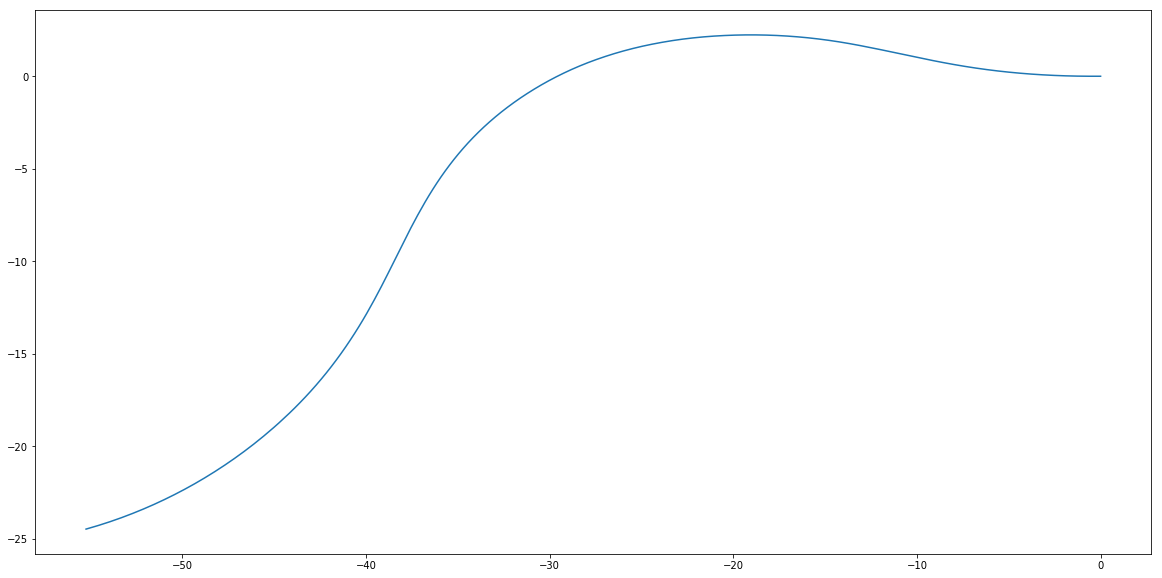

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(np.array(locations)[:, 0], np.array(locations)[:, 1])